# Example of SasRec training/inference with Parquet Module

In [1]:
from typing import Optional

import lightning as L
import pandas as pd

L.seed_everything(42)

import warnings
warnings.filterwarnings("ignore")

Seed set to 42


## Preparing data
In this example, we will be using the MovieLens dataset, namely the 1m subset. It's demonstrated a simple case, so only item ids will be used as model input.

---
**NOTE**

Current implementation of SasRec is able to handle item and interactions features. It does not take into account user features. 

---

In [2]:
interactions = pd.read_csv("./data/ml1m_ratings.dat", sep="\t", names=["user_id", "item_id","rating","timestamp"])
interactions = interactions.drop(columns=["rating"])

In [3]:
interactions["timestamp"] = interactions["timestamp"].astype("int64")
interactions = interactions.sort_values(by="timestamp")
interactions["timestamp"] = interactions.groupby("user_id").cumcount()
interactions

,user_id,item_id,timestamp
1000138,6040,858,0
1000153,6040,2384,1
999873,6040,593,2
1000007,6040,1961,3
1000192,6040,2019,4
...,...,...,...
825793,4958,2399,446
825438,4958,1407,447
825724,4958,3264,448
825731,4958,2634,449


### Encode catagorical data.
To ensure all categorical data is fit for training, it needs to be encoded using the `LabelEncoder` class. Create an instance of the encoder, providing a `LabelEncodingRule` for each categorcial column in the dataset that will be used in model. Note that ids of users and ids of items are always used.

In [4]:
from replay.preprocessing.label_encoder import LabelEncoder, LabelEncodingRule

encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id", default_value="last"),
        LabelEncodingRule("item_id", default_value="last"),
    ]
)
interactions = interactions.sort_values(by="item_id", ascending=True)
encoded_interactions = encoder.fit_transform(interactions)
encoded_interactions

,timestamp,user_id,item_id
0,12,0,0
1,68,1,0
2,67,2,0
3,12,3,0
4,140,4,0
...,...,...,...
1000204,14,4555,3705
1000205,90,2813,3705
1000206,70,2404,3705
1000207,25,5835,3705


### Split interactions into the train, validation and test datasets using LastNSplitter
We use widespread splitting strategy Last-One-Out. We filter out cold items and users for simplicity.

In [5]:
from replay.splitters import LastNSplitter

splitter = LastNSplitter(
    N=1,
    divide_column="user_id",
    query_column="user_id",
    strategy="interactions",
    drop_cold_users=True,
    drop_cold_items=True
)

test_events, test_gt = splitter.split(encoded_interactions)
validation_events, validation_gt = splitter.split(test_events)
train_events = validation_events

### Dataset preprocessing ("baking")
SasRec expects each user in the batch to provide their events in form of a sequence. For this reason, the event splits must be properly processed using the `groupby_sequences` function provided by RePlay.

In [6]:
from replay.data.nn.utils import groupby_sequences


def bake_data(full_data):
    grouped_interactions = groupby_sequences(events=full_data, groupby_col="user_id", sort_col="timestamp")
    return grouped_interactions

In [7]:
train_events = bake_data(train_events)

validation_events = bake_data(validation_events)
validation_gt = bake_data(validation_gt)

test_events = bake_data(test_events)
test_gt = bake_data(test_gt)

train_events

,user_id,timestamp,item_id
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 822, 2733, 2587, 2937, 3618, 2943, 708,..."
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3272, 3026, 2760, 851, 346, 3393, 1107, 515, ..."
2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[579, 1140, 1154, 2426, 1524, 1260, 2160, 2621..."
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1781, 2940, 2468, 890, 948, 106, 593, 309, 49..."
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1108, 2229, 21, 2435, 2142, 106, 1167, 593, 1..."
...,...,...,...
6035,6035,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 1279, 3151, 3321, 1178, 3301, 2501, 278..."
6036,6036,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1592, 2302, 1633, 1813, 2879, 1482, 2651, 250..."
6037,6037,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1971, 3500, 2077, 1666, 1399, 2651, 2748, 283..."
6038,6038,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1486, 1485, 3384, 3512, 3302, 3126, 3650, 330..."


To ensure we don't have unknown users in ground truth, we join validation events and validation ground truth (also join test events and test ground truth correspondingly) by user ids to leave only the common ones.  

In [8]:
def add_gt_to_events(events_df, gt_df):
    gt_to_join = gt_df[["user_id", "item_id"]].rename(columns={"item_id": "ground_truth"})

    events_df = events_df.merge(gt_to_join, on="user_id", how="inner")
    return events_df

validation_events = add_gt_to_events(validation_events, validation_gt)
test_events = add_gt_to_events(test_events, test_gt)

In [9]:
from pathlib import Path

data_dir = Path("temp/data/")
data_dir.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = data_dir / "train.parquet"
VAL_PATH = data_dir / "val.parquet"
PREDICT_PATH = data_dir / "test.parquet"

ENCODER_PATH = data_dir / "encoder"

In [10]:
train_events.to_parquet(TRAIN_PATH)
validation_events.to_parquet(VAL_PATH)
test_events.to_parquet(PREDICT_PATH)

encoder.save(ENCODER_PATH)

# Prepare to model training
### Create the tensor schema
A schema shows the correspondence of columns from the source dataset with the internal representation of tensors inside the model. It is required by the SasRec model to correctly create embeddings for every source column. Note that user_id does not required in `TensorSchema`.

Note that the **padding value** is the next value (item_id) after the last one. **Cardinality** is the number of unique values ​​given the padding value.

In [11]:
from replay.data import FeatureHint, FeatureType
from replay.data.nn import TensorFeatureInfo, TensorSchema


EMBEDDING_DIM = 64

encoder = encoder.load(ENCODER_PATH)
NUM_UNIQUE_ITEMS = len(encoder.mapping["item_id"])

tensor_schema = TensorSchema(
    [
        TensorFeatureInfo(
            name="item_id",
            is_seq=True,
            padding_value=NUM_UNIQUE_ITEMS,
            cardinality=NUM_UNIQUE_ITEMS + 1,  # taking into account padding
            embedding_dim=EMBEDDING_DIM,
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
        )
    ]
)

### Configure ParquetModule and transformation pipelines

The `ParquetModule` class enables training of models on large datasets by reading data in batch-wise way. This class initialized with **paths to every data split, a metadata dict containing information about shape and padding value of every column and a dict of transforms**. `ParquetModule`'s  "transform pipelines" are stage-specific modules implementing additional preprocessing to be performed on batch level right before the forward pass.  

For SasRec model, RePlay provides a function that generates a sequence of appropriate transforms for each data split named **make_default_sasrec_transforms**.

Internally this function creates the following transforms:
1) Training:
    1. Create a target, which contains the shifted item sequence that represents the next item in the sequence (for the next item prediction task).
    2. Rename features to match it with expected format by the model during training.
    3. Unsqueeze target (*positive_labels*) and it's padding mask (*target_padding_mask*) for getting required shape of this tensors for loss computation.
    4. Group input features to be embed in expected format.

2) Validation/Inference:
    1. Rename/group features to match it with expected format by the model during valdiation/inference.

If a different set of transforms is required, you can create them yourself and submit them to the ParquetModule in the form of a dictionary where the key is the name of the split, and the value is the list of transforms. Available transforms are in the replay/nn/transforms/.

**Note:** One of the transforms for the training data prepares the initial sequence for the task of Next Item Prediction so it shifts the sequence of items. For the final sequence length to be correct, you need to set shape of item_id in metadata as **model sequence length + shift**. Default shift value is 1.

In [12]:
import copy

import torch

from replay.data.nn import TensorSchema
from replay.nn.transform import GroupTransform, NextTokenTransform, RenameTransform, UnsqueezeTransform, ThresholdNegativeSamplingTransform

In [13]:
def make_sasrec_transforms(
    tensor_schema: TensorSchema, query_column: str = "query_id", num_negative_samples: int = 128,
) -> dict[str, list[torch.nn.Module]]:
    item_column = tensor_schema.item_id_feature_name
    vocab_size = tensor_schema[item_column].cardinality
    train_transforms = [
        ThresholdNegativeSamplingTransform(vocab_size, num_negative_samples),
        NextTokenTransform(label_field=item_column, query_features=query_column, shift=1),
        RenameTransform(
            {
                query_column: "query_id",
                f"{item_column}_mask": "padding_mask",
                "positive_labels_mask": "target_padding_mask",
            }
        ),
        UnsqueezeTransform("target_padding_mask", -1),
        UnsqueezeTransform("positive_labels", -1),
        GroupTransform({"feature_tensors": [item_column]}),
    ]

    val_transforms = [
        RenameTransform({query_column: "query_id", f"{item_column}_mask": "padding_mask"}),
        GroupTransform({"feature_tensors": [item_column]}),
    ]
    test_transforms = copy.deepcopy(val_transforms)

    predict_transforms = copy.deepcopy(val_transforms)

    transforms = {
        "train": train_transforms,
        "validate": val_transforms,
        "test": test_transforms,
        "predict": predict_transforms,
    }

    return transforms

transforms = make_sasrec_transforms(tensor_schema, query_column="user_id")

In [14]:
MAX_SEQ_LEN = 50

def create_meta(shape: int, gt_shape: Optional[int] = None):
    meta = {
        "user_id": {},
        "item_id": {"shape": shape, "padding": tensor_schema["item_id"].padding_value},
    }
    if gt_shape is not None:
        meta.update({"ground_truth": {"shape": gt_shape, "padding": -1}})

    return meta

train_metadata = {
    "train": create_meta(shape=MAX_SEQ_LEN+1),
    "validate": create_meta(shape=MAX_SEQ_LEN, gt_shape=1),
}

In [15]:
from replay.data.nn import ParquetModule

BATCH_SIZE = 32

parquet_module = ParquetModule(
    train_path=TRAIN_PATH,
    validate_path=VAL_PATH,
    batch_size=BATCH_SIZE,
    metadata=train_metadata,
    transforms=transforms,
)

## Train model
### Create SasRec model instance and run the training stage using lightning
We may now train the model using the Lightning trainer class. 

RePlay's implementation of SasRec is designed in a modular, **block-based approach**. Instead of passing configuration parameters to the constructor, SasRec is now built by providing fully initialized components that makes the model more flexible and easier to extend.

#### Default Configuration

Default SasRec model may be created quickly via method **from_params**. Default model instance has CE loss, original SasRec transformer layes, and embeddings are aggregated via sum.

In [16]:
from replay.nn.sequential import SasRec
from typing import Literal
def make_sasrec(
    schema: TensorSchema,
    embedding_dim: int = 192,
    num_heads: int = 4,
    num_blocks: int = 2,
    max_sequence_length: int = 50,
    dropout: float = 0.3,
    excluded_features: Optional[list[str]] = None,
    categorical_list_feature_aggregation_method: Literal["sum", "mean", "max"] = "sum",
) -> SasRec:
    from replay.nn.sequential.sasrec import SasRecBody, SasRecTransformerLayer
    from replay.nn.agg import SumAggregator
    from replay.nn.embedding import SequenceEmbedding
    from replay.nn.loss import CE, CESampled
    from replay.nn.mask import DefaultAttentionMask
    from replay.nn.sequential.sasrec.agg import PositionAwareAggregator
    from replay.nn.sequential.sasrec.transformer import SasRecTransformerLayer
    excluded_features = [
        schema.query_id_feature_name,
        schema.timestamp_feature_name,
        *(excluded_features or []),
    ]
    excluded_features = list(set(excluded_features))
    body = SasRecBody(
        embedder=SequenceEmbedding(
            schema=schema,
            categorical_list_feature_aggregation_method=categorical_list_feature_aggregation_method,
            excluded_features=excluded_features,
        ),
        embedding_aggregator=PositionAwareAggregator(
            embedding_aggregator=SumAggregator(embedding_dim=embedding_dim),
            max_sequence_length=max_sequence_length,
            dropout=dropout,
        ),
        attn_mask_builder=DefaultAttentionMask(
            reference_feature_name=schema.item_id_feature_name,
            num_heads=num_heads,
        ),
        encoder=SasRecTransformerLayer(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            num_blocks=num_blocks,
            dropout=dropout,
            activation="relu",
        ),
        output_normalization=torch.nn.LayerNorm(embedding_dim),
    )
    padding_idx = schema.item_id_features.item().padding_value
    return SasRec(
        body=body,
        loss=CESampled(padding_idx=padding_idx),
    )

In [17]:
NUM_BLOCKS = 2
NUM_HEADS = 2
DROPOUT = 0.3

sasrec = make_sasrec(
    schema=tensor_schema,
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT,
)

A universal PyTorch Lightning module is provided. It can work with any NN model.

In [18]:
from replay.nn.lightning.optimizer import OptimizerFactory
from replay.nn.lightning.scheduler import LRSchedulerFactory
from replay.nn.lightning import LightningModule

model = LightningModule(
    sasrec,
    optimizer_factory=OptimizerFactory(),
    lr_scheduler_factory=LRSchedulerFactory(),
)

To facilitate training, we add the following callbacks:
1) `ModelCheckpoint` - to save the best trained model based on its Recall metric. It's a default Lightning Callback.
1) `ComputeMetricsCallback` - to display a detailed validation metric matrix after each epoch. It's a custom RePlay callback for computing recsys metrics on validation and test stages.


In [19]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from replay.nn.lightning.callback import ComputeMetricsCallback


checkpoint_callback = ModelCheckpoint(
    dirpath="sasrec/checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="recall@10",
    mode="max",
)

validation_metrics_callback = ComputeMetricsCallback(
    metrics=["map", "ndcg", "recall"],
    ks=[1, 5, 10, 20],
    item_count=NUM_UNIQUE_ITEMS,
)

csv_logger = CSVLogger(save_dir="sasrec/logs/train", name="SasRec-example")

trainer = L.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, validation_metrics_callback],
    logger=csv_logger,
)

trainer.fit(model, datamodule=parquet_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode  | FLOPs
-------------------------------------------------
0 | model | SasRec | 291 K  | train | 0    
-------------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 189: 'recall@10' reached 0.02517 (best 0.02517), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=0-step=189-v3.ckpt' as top 1


k              1        10        20         5
map     0.003477  0.008391  0.009940  0.006889
ndcg    0.003477  0.012236  0.018080  0.008533
recall  0.003477  0.025170  0.048684  0.013578



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 378: 'recall@10' reached 0.04090 (best 0.04090), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=1-step=378-v2.ckpt' as top 1


k              1        10        20         5
map     0.005133  0.013343  0.015591  0.011023
ndcg    0.005133  0.019693  0.028004  0.014007
recall  0.005133  0.040901  0.074019  0.023183



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 567: 'recall@10' reached 0.06773 (best 0.06773), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=2-step=567.ckpt' as top 1


k              1        10        20         5
map     0.008776  0.021569  0.024780  0.017903
ndcg    0.008776  0.032154  0.044198  0.022983
recall  0.008776  0.067726  0.116079  0.038748



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 756: 'recall@10' reached 0.08197 (best 0.08197), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=3-step=756-v3.ckpt' as top 1


k             1        10        20         5
map     0.00977  0.024920  0.029111  0.019702
ndcg    0.00977  0.037940  0.053492  0.025112
recall  0.00977  0.081967  0.144064  0.041894



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 945: 'recall@10' reached 0.10051 (best 0.10051), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=4-step=945-v4.ckpt' as top 1


k              1        10        20         5
map     0.011757  0.032053  0.036894  0.025981
ndcg    0.011757  0.047823  0.065510  0.033102
recall  0.011757  0.100513  0.170558  0.054976



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1134: 'recall@10' reached 0.11707 (best 0.11707), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=5-step=1134-v1.ckpt' as top 1


k            1        10        20         5
map     0.0154  0.038303  0.043634  0.031517
ndcg    0.0154  0.056389  0.076198  0.039699
recall  0.0154  0.117072  0.196225  0.064911



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1323: 'recall@10' reached 0.13214 (best 0.13214), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=6-step=1323-v2.ckpt' as top 1


k              1        10        20         5
map     0.015069  0.042212  0.047618  0.034832
ndcg    0.015069  0.062962  0.082865  0.044922
recall  0.015069  0.132141  0.211293  0.076006



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1512: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.041482  0.047466  0.033985
ndcg    0.015731  0.061963  0.083911  0.043462
recall  0.015731  0.130651  0.217751  0.072694



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1701: 'recall@10' reached 0.14406 (best 0.14406), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=8-step=1701-v1.ckpt' as top 1


k              1        10        20         5
map     0.015897  0.045616  0.051492  0.037233
ndcg    0.015897  0.068287  0.089852  0.047670
recall  0.015897  0.144064  0.229674  0.079649



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1890: 'recall@10' reached 0.15102 (best 0.15102), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=9-step=1890-v2.ckpt' as top 1


k              1        10        20         5
map     0.017387  0.048506  0.054854  0.040073
ndcg    0.017387  0.072139  0.095364  0.051380
recall  0.017387  0.151018  0.243087  0.086107



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 2079: 'recall@10' reached 0.15201 (best 0.15201), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=10-step=2079.ckpt' as top 1


k             1        10        20         5
map     0.01689  0.048957  0.055559  0.040876
ndcg    0.01689  0.072775  0.096923  0.052810
recall  0.01689  0.152012  0.247723  0.089419



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 2268: 'recall@10' reached 0.16128 (best 0.16128), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=11-step=2268.ckpt' as top 1


k              1        10        20         5
map     0.016228  0.049785  0.056337  0.040514
ndcg    0.016228  0.075524  0.099693  0.052985
recall  0.016228  0.161285  0.257493  0.091406



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 2457: 'recall@10' reached 0.16327 (best 0.16327), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=12-step=2457-v1.ckpt' as top 1


k              1        10        20         5
map     0.014738  0.048876  0.055841  0.039215
ndcg    0.014738  0.075207  0.100830  0.051456
recall  0.014738  0.163272  0.265110  0.089088



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 2646: 'recall@10' reached 0.16393 (best 0.16393), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=13-step=2646.ckpt' as top 1


k              1        10        20         5
map     0.016725  0.051229  0.058088  0.041919
ndcg    0.016725  0.077239  0.102477  0.054437
recall  0.016725  0.163934  0.264282  0.092896



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2835: 'recall@10' reached 0.16791 (best 0.16791), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=14-step=2835.ckpt' as top 1


k              1        10        20         5
map     0.018049  0.052408  0.059556  0.042344
ndcg    0.018049  0.079003  0.105266  0.054474
recall  0.018049  0.167909  0.272231  0.091737



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 3024: 'recall@10' reached 0.16907 (best 0.16907), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=15-step=3024.ckpt' as top 1


k              1        10        20         5
map     0.017718  0.052563  0.059905  0.042822
ndcg    0.017718  0.079424  0.106455  0.055627
recall  0.017718  0.169068  0.276536  0.095049



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 3213: 'recall@10' reached 0.17255 (best 0.17255), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=16-step=3213.ckpt' as top 1


k              1        10        20         5
map     0.016725  0.053275  0.060719  0.043368
ndcg    0.016725  0.080840  0.108407  0.056778
recall  0.016725  0.172545  0.282497  0.098029



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 3402: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015069  0.052175  0.059507  0.042386
ndcg    0.015069  0.079773  0.106812  0.055673
recall  0.015069  0.171717  0.279351  0.096374



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 3591: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017387  0.052979  0.060514  0.042849
ndcg    0.017387  0.079924  0.107494  0.055138
recall  0.017387  0.169896  0.279185  0.092731



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 3780: 'recall@10' reached 0.18066 (best 0.18066), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=19-step=3780.ckpt' as top 1


k              1        10        20         5
map     0.016559  0.053610  0.060994  0.042965
ndcg    0.016559  0.082830  0.110151  0.056616
recall  0.016559  0.180659  0.289617  0.098692



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 3969: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015069  0.052912  0.060238  0.042455
ndcg    0.015069  0.081482  0.108433  0.056028
recall  0.015069  0.176685  0.283822  0.097698



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 4158: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.053080  0.060646  0.043241
ndcg    0.015731  0.080854  0.108792  0.056898
recall  0.015731  0.173207  0.284484  0.098857



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 4347: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017056  0.055227  0.062985  0.044949
ndcg    0.017056  0.083916  0.112344  0.058574
recall  0.017056  0.179666  0.292433  0.100348



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 4536: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015069  0.052468  0.060395  0.042041
ndcg    0.015069  0.080925  0.110088  0.055468
recall  0.015069  0.175857  0.291770  0.096705



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 4725: 'recall@10' reached 0.18397 (best 0.18397), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=24-step=4725.ckpt' as top 1


k              1        10        20         5
map     0.017718  0.055757  0.063565  0.044925
ndcg    0.017718  0.085273  0.114202  0.058594
recall  0.017718  0.183971  0.299387  0.100513



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 4914: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017387  0.054950  0.062547  0.044381
ndcg    0.017387  0.083432  0.111543  0.057612
recall  0.017387  0.178506  0.290611  0.098195



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 5103: 'recall@10' reached 0.18463 (best 0.18463), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=26-step=5103.ckpt' as top 1


k              1        10        20         5
map     0.019043  0.057219  0.064977  0.046506
ndcg    0.019043  0.086570  0.114830  0.060294
recall  0.019043  0.184633  0.296407  0.102666



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 5292: 'recall@10' was not in top 1


k              1        10        20         5
map     0.019208  0.057371  0.065001  0.046650
ndcg    0.019208  0.085884  0.114015  0.059848
recall  0.019208  0.180825  0.292764  0.100182



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 5481: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018381  0.056056  0.063808  0.045615
ndcg    0.018381  0.085206  0.113792  0.059325
recall  0.018381  0.182812  0.296572  0.101507



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 5670: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.054551  0.062793  0.044119
ndcg    0.01689  0.083030  0.113385  0.057502
recall  0.01689  0.178010  0.298725  0.098526



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 5859: 'recall@10' reached 0.18828 (best 0.18828), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=30-step=5859.ckpt' as top 1


k              1        10        20         5
map     0.017387  0.057006  0.064480  0.046299
ndcg    0.017387  0.087281  0.114612  0.060979
recall  0.017387  0.188276  0.296572  0.106143



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 6048: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016559  0.055557  0.063455  0.045518
ndcg    0.016559  0.084519  0.113808  0.059953
recall  0.016559  0.180825  0.297731  0.104322



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 6237: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015234  0.055037  0.063161  0.044312
ndcg    0.015234  0.085493  0.115172  0.059173
recall  0.015234  0.187117  0.304686  0.104984



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 6426: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015897  0.055037  0.063057  0.043967
ndcg    0.015897  0.085474  0.114917  0.058397
recall  0.015897  0.187117  0.304024  0.102832



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 6615: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014738  0.053996  0.061706  0.042709
ndcg    0.014738  0.083953  0.112215  0.056473
recall  0.014738  0.183971  0.296076  0.098692



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 6804: 'recall@10' reached 0.18844 (best 0.18844), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=35-step=6804-v1.ckpt' as top 1


k              1        10        20         5
map     0.015069  0.054859  0.063045  0.043283
ndcg    0.015069  0.085649  0.116068  0.057529
recall  0.015069  0.188442  0.309985  0.101341



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 6993: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.057387  0.065605  0.046467
ndcg    0.016725  0.087272  0.117565  0.060911
recall  0.016725  0.186455  0.307004  0.105150



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 7182: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014903  0.055713  0.063883  0.044455
ndcg    0.014903  0.086266  0.116276  0.058719
recall  0.014903  0.188111  0.307336  0.102335



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 7371: 'recall@10' reached 0.19208 (best 0.19208), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=38-step=7371.ckpt' as top 1


k              1        10        20         5
map     0.015897  0.056195  0.063902  0.044337
ndcg    0.015897  0.087493  0.115857  0.058652
recall  0.015897  0.192085  0.304852  0.102666



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 7560: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016559  0.056413  0.064644  0.045493
ndcg    0.016559  0.086769  0.117049  0.059937
recall  0.016559  0.188111  0.308495  0.104322



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 7749: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014406  0.055492  0.063463  0.044392
ndcg    0.014406  0.086624  0.116225  0.059581
recall  0.014406  0.190263  0.308495  0.106309



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 7938: 'recall@10' reached 0.19225 (best 0.19225), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=41-step=7938.ckpt' as top 1


k              1        10        20         5
map     0.017221  0.058234  0.066382  0.047257
ndcg    0.017221  0.089155  0.118997  0.062111
recall  0.017221  0.192250  0.310647  0.107634



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 8127: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018381  0.057681  0.065612  0.046263
ndcg    0.018381  0.088403  0.117568  0.060508
recall  0.018381  0.191091  0.307004  0.104322



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 8316: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.057188  0.065122  0.045949
ndcg    0.015731  0.088375  0.117464  0.060972
recall  0.015731  0.192250  0.307667  0.107137



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 8505: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014903  0.055369  0.063525  0.044646
ndcg    0.014903  0.086007  0.115973  0.059935
recall  0.014903  0.187779  0.306839  0.106971



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 8694: 'recall@10' reached 0.19374 (best 0.19374), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=45-step=8694.ckpt' as top 1


k             1        10        20         5
map     0.01391  0.055919  0.063806  0.044141
ndcg    0.01391  0.087688  0.116770  0.058898
recall  0.01391  0.193741  0.309488  0.104156



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 8883: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018546  0.057837  0.065681  0.046448
ndcg    0.018546  0.088962  0.118050  0.061033
recall  0.018546  0.193078  0.309157  0.105978



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 9072: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016559  0.057167  0.065194  0.045987
ndcg    0.016559  0.088154  0.117904  0.060651
recall  0.016559  0.191588  0.310316  0.105647



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 9261: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.058332  0.066214  0.047022
ndcg    0.01689  0.089275  0.118570  0.061644
recall  0.01689  0.192416  0.309488  0.106475



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 9450: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016393  0.057926  0.066244  0.046906
ndcg    0.016393  0.088820  0.119375  0.062076
recall  0.016393  0.191422  0.312800  0.108627



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 9639: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017718  0.058476  0.066364  0.046785
ndcg    0.017718  0.089596  0.118568  0.061171
recall  0.017718  0.193410  0.308495  0.105315



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 9828: 'recall@10' reached 0.19540 (best 0.19540), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=51-step=9828-v1.ckpt' as top 1


k              1        10        20         5
map     0.015731  0.057566  0.065119  0.045990
ndcg    0.015731  0.089326  0.117305  0.060894
recall  0.015731  0.195397  0.307004  0.106640



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 10017: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01954  0.058868  0.067041  0.048454
ndcg    0.01954  0.088730  0.118800  0.063159
recall  0.01954  0.188276  0.307832  0.108462



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 10206: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017718  0.058614  0.066505  0.047370
ndcg    0.017718  0.089564  0.118682  0.062093
recall  0.017718  0.192747  0.308660  0.107303



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 10395: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.057676  0.065385  0.046299
ndcg    0.016725  0.089061  0.117540  0.061333
recall  0.016725  0.193741  0.307170  0.107634



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 10584: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016062  0.056661  0.064644  0.045372
ndcg    0.016062  0.087800  0.117280  0.060313
recall  0.016062  0.191588  0.308992  0.106309



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 10773: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018049  0.058768  0.066948  0.047558
ndcg    0.018049  0.090098  0.120345  0.062504
recall  0.018049  0.194734  0.315284  0.108462



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 10962: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014572  0.053518  0.062111  0.042355
ndcg    0.014572  0.083976  0.115510  0.056682
recall  0.014572  0.185792  0.310979  0.100845



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 11151: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018049  0.058147  0.066599  0.047524
ndcg    0.018049  0.088199  0.119005  0.062165
recall  0.018049  0.188276  0.310151  0.107137



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 11340: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014406  0.055658  0.063896  0.044665
ndcg    0.014406  0.086842  0.117136  0.059875
recall  0.014406  0.190760  0.311144  0.106640



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 11529: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.056472  0.064719  0.045739
ndcg    0.015731  0.087657  0.117903  0.061421
recall  0.015731  0.191422  0.311475  0.109786



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 11718: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.057109  0.065266  0.045570
ndcg    0.01689  0.088058  0.118054  0.060104
recall  0.01689  0.191257  0.310482  0.104819



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 11907: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014738  0.056182  0.064093  0.044226
ndcg    0.014738  0.087940  0.116915  0.058911
recall  0.014738  0.193906  0.308826  0.103991



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 12096: 'recall@10' reached 0.19556 (best 0.19556), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=63-step=12096.ckpt' as top 1


k              1        10        20         5
map     0.016228  0.058258  0.066323  0.047014
ndcg    0.016228  0.089951  0.119723  0.062421
recall  0.016228  0.195562  0.314125  0.109786



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 12285: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.058308  0.066315  0.047469
ndcg    0.016725  0.089611  0.119061  0.063139
recall  0.016725  0.193741  0.310813  0.111442



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 12474: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015069  0.055754  0.063692  0.043901
ndcg    0.015069  0.087118  0.116341  0.058438
recall  0.015069  0.191754  0.307998  0.103163



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 12663: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015234  0.056930  0.065395  0.045352
ndcg    0.015234  0.088645  0.119658  0.060367
recall  0.015234  0.194403  0.317437  0.106475



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 12852: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014241  0.055383  0.063480  0.044845
ndcg    0.014241  0.086363  0.116422  0.060699
recall  0.014241  0.189270  0.309323  0.109621



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 13041: 'recall@10' reached 0.19622 (best 0.19622), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=68-step=13041.ckpt' as top 1


k              1        10        20         5
map     0.018712  0.058867  0.067064  0.047028
ndcg    0.018712  0.090484  0.120756  0.061726
recall  0.018712  0.196225  0.316774  0.107137



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 13230: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018712  0.059296  0.067623  0.047822
ndcg    0.018712  0.090358  0.121063  0.062465
recall  0.018712  0.193906  0.316112  0.107468



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 13419: 'recall@10' reached 0.19672 (best 0.19672), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=70-step=13419.ckpt' as top 1


k              1        10        20         5
map     0.017718  0.058932  0.066943  0.047301
ndcg    0.017718  0.090675  0.119968  0.062253
recall  0.017718  0.196721  0.312800  0.108296



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 13608: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017056  0.057241  0.065559  0.045708
ndcg    0.017056  0.088863  0.119476  0.060634
recall  0.017056  0.194569  0.316278  0.106640



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 13797: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015069  0.056120  0.064450  0.044969
ndcg    0.015069  0.087871  0.118417  0.060586
recall  0.015069  0.193741  0.314953  0.108793



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 13986: 'recall@10' reached 0.19854 (best 0.19854), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=73-step=13986.ckpt' as top 1


k              1        10        20         5
map     0.016559  0.057389  0.065353  0.045104
ndcg    0.016559  0.089853  0.119195  0.059893
recall  0.016559  0.198543  0.315284  0.105481



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 14175: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015565  0.056737  0.065008  0.045043
ndcg    0.015565  0.088335  0.118772  0.059753
recall  0.015565  0.193906  0.314953  0.104984



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 14364: 'recall@10' was not in top 1


k            1        10        20         5
map     0.0154  0.056695  0.064954  0.044974
ndcg    0.0154  0.088831  0.119369  0.059974
recall  0.0154  0.196390  0.318099  0.106143



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 14553: 'recall@10' reached 0.19904 (best 0.19904), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=76-step=14553.ckpt' as top 1


k              1        10        20         5
map     0.014406  0.056638  0.064821  0.044654
ndcg    0.014406  0.089447  0.119451  0.060199
recall  0.014406  0.199040  0.318099  0.108130



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 14742: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.057254  0.065636  0.045783
ndcg    0.01689  0.088655  0.119626  0.060673
recall  0.01689  0.193575  0.316940  0.106640



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 14931: 'recall@10' was not in top 1


k              1        10        20         5
map     0.013413  0.053570  0.062183  0.042154
ndcg    0.013413  0.084824  0.116217  0.056864
recall  0.013413  0.189270  0.313462  0.102169



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 15120: 'recall@10' was not in top 1


k              1        10        20         5
map     0.013744  0.056911  0.065346  0.045518
ndcg    0.013744  0.089081  0.119783  0.061084
recall  0.013744  0.196225  0.317602  0.108793



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 15309: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017056  0.059605  0.067669  0.048805
ndcg    0.017056  0.091420  0.121109  0.064925
recall  0.017056  0.197218  0.315284  0.114589



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 15498: 'recall@10' reached 0.19970 (best 0.19970), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=81-step=15498-v1.ckpt' as top 1


k              1        10        20         5
map     0.019208  0.059915  0.067934  0.047475
ndcg    0.019208  0.092051  0.121520  0.061684
recall  0.019208  0.199702  0.316774  0.105315



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 15687: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017056  0.059126  0.066993  0.047193
ndcg    0.017056  0.091040  0.119902  0.061589
recall  0.017056  0.197880  0.312469  0.105647



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 15876: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016393  0.058910  0.067300  0.047367
ndcg    0.016393  0.090708  0.121604  0.062527
recall  0.016393  0.196556  0.319424  0.108958



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 16065: 'recall@10' was not in top 1


k            1        10        20         5
map     0.0154  0.057330  0.065707  0.046324
ndcg    0.0154  0.088907  0.119815  0.061892
recall  0.0154  0.194072  0.317105  0.109786



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 16254: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017884  0.058865  0.067077  0.046901
ndcg    0.017884  0.090545  0.120613  0.061410
recall  0.017884  0.196390  0.315615  0.105978



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 16443: 'recall@10' was not in top 1


k              1        10        20         5
map     0.013578  0.056565  0.064611  0.044949
ndcg    0.013578  0.088694  0.118386  0.060223
recall  0.013578  0.195728  0.313959  0.106971



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 16632: 'recall@10' reached 0.20003 (best 0.20003), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=87-step=16632.ckpt' as top 1


k              1        10        20         5
map     0.014738  0.057765  0.065777  0.045747
ndcg    0.014738  0.090573  0.120003  0.061197
recall  0.014738  0.200033  0.316940  0.108627



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 16821: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014406  0.056543  0.064898  0.045063
ndcg    0.014406  0.088396  0.118998  0.060280
recall  0.014406  0.194569  0.315946  0.106971



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 17010: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.057330  0.065518  0.045824
ndcg    0.015731  0.088940  0.118949  0.060987
recall  0.015731  0.194237  0.313297  0.107634



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 17199: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015897  0.058550  0.066817  0.046854
ndcg    0.015897  0.090655  0.121206  0.062134
recall  0.015897  0.197549  0.319258  0.108958



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 17388: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014075  0.057416  0.065911  0.046128
ndcg    0.014075  0.089700  0.120977  0.062278
recall  0.014075  0.196887  0.321245  0.111939



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 17577: 'recall@10' reached 0.20036 (best 0.20036), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=92-step=17577-v2.ckpt' as top 1


k              1        10        20         5
map     0.014241  0.057366  0.065310  0.044878
ndcg    0.014241  0.090287  0.119605  0.059684
recall  0.014241  0.200364  0.317105  0.104984



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 17766: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017221  0.058259  0.066380  0.047455
ndcg    0.017221  0.089409  0.119171  0.063038
recall  0.017221  0.193078  0.311144  0.111111



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 17955: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015897  0.058542  0.066742  0.046857
ndcg    0.015897  0.090490  0.120543  0.062166
recall  0.015897  0.196721  0.315946  0.109124



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 18144: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017221  0.059014  0.067464  0.047632
ndcg    0.017221  0.090545  0.121542  0.062936
recall  0.017221  0.195397  0.318430  0.109952



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 18333: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017056  0.059395  0.067978  0.047806
ndcg    0.017056  0.091108  0.122518  0.062947
recall  0.017056  0.196721  0.321245  0.109455



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 18522: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.057509  0.065688  0.046131
ndcg    0.015731  0.089842  0.119812  0.062111
recall  0.015731  0.197549  0.316443  0.111442



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 18711: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014241  0.057645  0.065858  0.045747
ndcg    0.014241  0.090083  0.120261  0.061015
recall  0.014241  0.198212  0.318099  0.107799



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 18900: 'recall@10' reached 0.20136 (best 0.20136), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=99-step=18900.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


k             1        10        20         5
map     0.01391  0.056347  0.064440  0.044130
ndcg    0.01391  0.089694  0.119503  0.059647
recall  0.01391  0.201358  0.319921  0.107468



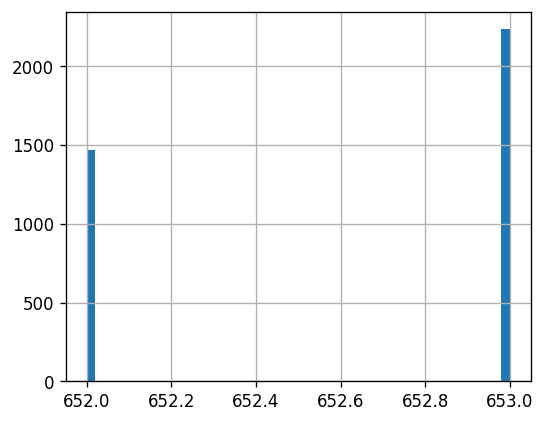

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 4), dpi = 120)
plt.hist(transforms["train"][0].frequencies.cpu().numpy(), bins = 50)
plt.grid()


Now we can get the best model path stored in the checkpoint callback.

In [22]:
best_model_path = checkpoint_callback.best_model_path
best_model_path

'/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=99-step=18900.ckpt'

## Inference

To obtain model scores, we will load the weights from the best checkpoint. To do this, we use the `LightningModule`, provide there the path to the checkpoint and the model instance.

In [23]:
import replay
torch.serialization.add_safe_globals([
    replay.nn.lightning.optimizer.OptimizerFactory,
    replay.nn.lightning.scheduler.LRSchedulerFactory
])

In [24]:
sasrec = make_sasrec(
    schema=tensor_schema,
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT,
)

best_model = LightningModule.load_from_checkpoint(best_model_path, model=sasrec)
best_model.eval();

Configure `ParquetModule` for inference

In [25]:
inference_metadata = {"predict": create_meta(shape=MAX_SEQ_LEN)}

parquet_module = ParquetModule(
    predict_path=PREDICT_PATH,
    batch_size=BATCH_SIZE,
    metadata=inference_metadata,
    transforms=transforms,
)

During inference, we can use `TopItemsCallback`. Such callback allows you to get scores for each user throughout the entire catalog and get recommendations in the form of ids of items with the highest score values.


Recommendations can be fetched in four formats: PySpark DataFrame, Pandas DataFrame, Polars DataFrame or raw PyTorch tensors. Each of the types corresponds a callback. In this example, we'll be using the `PandasTopItemsCallback`.

In [26]:
from replay.nn.lightning.callback import PandasTopItemsCallback

csv_logger = CSVLogger(save_dir="sasrec/logs/test", name="SasRec-example")

TOPK = [1, 5, 10, 20]

pandas_prediction_callback = PandasTopItemsCallback(
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
)

trainer = L.Trainer(callbacks=[pandas_prediction_callback], logger=csv_logger, inference_mode=True)
trainer.predict(best_model, datamodule=parquet_module, return_predictions=False)

pandas_res = pandas_prediction_callback.get_result()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
pandas_res

,user_id,item_id,score
0,0,486,7.196251
0,0,101,7.086551
0,0,210,6.872698
0,0,1613,6.834656
0,0,357,6.555361
...,...,...,...
6037,6039,84,11.528885
6037,6039,2700,11.400557
6037,6039,2557,11.273298
6037,6039,2634,11.121119


### Calculating metrics

*test_gt* is already encoded, so we can use it for computing metrics.

In [28]:
from replay.metrics import MAP, OfflineMetrics, Precision, Recall
from replay.metrics.torch_metrics_builder import metrics_to_df

In [29]:
result_metrics = OfflineMetrics(
    [Recall(TOPK), Precision(TOPK), MAP(TOPK)],
    query_column="user_id",
    rating_column="score",
)(pandas_res, test_gt.explode("item_id"))

In [30]:
metrics_to_df(result_metrics)

k,1,10,20,5
MAP,0.016065,0.056637,0.064067,0.045948
Precision,0.016065,0.018665,0.014798,0.021133
Recall,0.016065,0.186651,0.295959,0.105664


Let's call the `inverse_transform` encoder's function to get the final dataframe with recommendations

In [31]:
encoder.inverse_transform(pandas_res)

,user_id,item_id,score
0,2012,500,7.196251
0,2012,104,7.086551
0,2012,216,6.872698
0,2012,1777,6.834656
0,2012,367,6.555361
...,...,...,...
6037,5727,86,11.528885
6037,5727,2907,11.400557
6037,5727,2762,11.273298
6037,5727,2841,11.121119
